# Comparison of models to predict sells

Goal of this notebook : 
In this notebook, we'll try to solve a regression problem and will analyze the different metrics to evaluate our models. <br/>
Let's first have a look of the different metrics for a regression problem :

----------
### MAPE (Mean Absolute Percentage Error)
MAPE $ = \frac{1}{n} \sum_{i=1}^{n} \mid \frac{y_i - \hat{y_i}}{y_i}\mid $
<br/><br/>
**Advantages**
We used MAPE if : <br/>
- We prefer not to overestimate our prediction
- We do not want to penalize more huge differences between predictions and true value (because of the use of L1 norm)
- We need a scale-independent metric (because of the division by y)
- We need a percentage (useful for business purpose)

**Drawbacks** :
- It can be used if an only if :      $y_i >0,$ $ \forall i \in 1,...,n$ <br/>
- If the predictions are too low MAPE won't be higher than 100%. But if the predictions are too high, $\mid \frac{y_i - \hat{y_i}}{y_i}\mid$ will be high and thus MAPE too. <br/>
Example with n=1 : if : $\hat{y_i}=1,y_i=30$, then MAPE = 29/30     but if : $\hat{y_i}=30,y_i=1$, then MAPE = 29  <br/><br/>
- From last point, we will penalize more if predictions is higher than the true value and thus, the predictions will tend to be lower than the true values. 
<br/>
------------
### MAE (Mean Absolute Error)
<br/>
MAE $ = \frac{1}{n} \sum_{i=1}^{n} \mid y_i - \hat{y_i}\mid $<br/><br/>
**Advantages**
- MAE can be used with any value of y
- No penalization of very bad predictions (L1 norm)


**Drawbacks**

- Indifferent to the direction of errors
<br/>
----------
### RMSE (Root Mean Squared Error)
<br/>
RMSE $ =\sqrt{\frac{1}{n}\sum_{i=1}^{n} (y_i - \hat{y_i})^2}$<br/><br/>
**Advantages**
- It penalizes more bad predictions 

**Drawbacks**
- Increase with the size of the test set and does not allow to compare models with different test sets
- Not easily understandable because of the root of the square and not a percentage measure

----
### MSE (Mean Squared Error)

MSE $ =\frac{1}{n}\sum_{i=1}^{n} (y_i - \hat{y_i})^2$<br/> <br/>

Same properties as RMSE. The difference with RMSE is in the root.<br/> RMSE is a distance and is more easily interpretable than MSE.<br/> RMSE is in average, the distance between the virtual regression line and the observation outputs

----- 

To learn more about state of the art :https://www.sciencedirect.com/science/article/pii/S0169207016000121 <br/> 
MAE vs RMSE : https://medium.com/human-in-a-machine-world/mae-and-rmse-which-metric-is-better-e60ac3bde13d <br/> 

------
## Introduction 
-------

We try some easy models to predict the sells of "a famous milk company". 
We study the impact of the MAPE metric with some plots.
We'll also try to see the differences between a time model like ARIMA and usual models like XGB,RF or Gradient Boosting. 
Unfortunately, data are private and not acessible.

The data is made of informations about :
- the supermarket seller : Enseigne
- the date of the observations : Week, Year, Date
- the type of product sold : MK1 
- the type of discount : Meca and Pack
- the amount of discount : Plage
- the number of days the discount is in the supermarket : Days_uplifts

Choose the supermarket and the kind of product you would like to predict by filling the following variables :
The product names are :
 - 'F0W'
 - 'F56'
 - 'F8M'
 - 'FHG'
 - 'VR3'
 
The market names are 
- 'Auchan' 
- 'Carrefour'
- 'Carrefour Market'
- 'Casino SM'
- 'Cora'
- 'Geant'
- 'Monoprix'
- 'SM Match  Prospectus'
- 'Systeme U'

If no change, let's assume that we want to stuy the product 'F0W' in the market 'Carrefour Market'

In [136]:
name_market='Carrefour Market'
name_product='F0W'

In [137]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from math import sqrt
import matplotlib
from sklearn.ensemble import RandomForestRegressor
from statsmodels.tsa.arima_model import ARIMA
from matplotlib import pyplot
import xgboost
from sklearn import metrics
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV

In [138]:
df=pd.read_excel('/Users/newuser/Downloads/Waters.xlsx')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8685 entries, 0 to 8684
Data columns (total 12 columns):
Client 4        8685 non-null object
Enseigne        8685 non-null object
Date            8685 non-null float64
Week            8685 non-null int64
Year            8685 non-null int64
MG1             8685 non-null object
Sell_Out        8685 non-null float64
Theme           2963 non-null object
Mecanisme       2963 non-null object
Pack            2963 non-null object
Days_Uplifts    2963 non-null float64
Plage           2963 non-null float64
dtypes: float64(4), int64(2), object(6)
memory usage: 814.3+ KB


In [139]:
# ex: change 2014.01 to 2014-01-08
df['Date']=pd.to_datetime(df.Year.astype(str), format='%Y') \
+ pd.to_timedelta(df.Week.mul(7).astype(str) + ' days')
df=df.sort_values(by=['Date'])
#df_time=pd.to_datetime(new_df.Year.astype(str), format='%Y') + pd.to_timedelta(new_df.Week.mul(7).astype(str) + ' days')

In [140]:
df.head()

,Client 4,Enseigne,Date,Week,Year,MG1,Sell_Out,Theme,Mecanisme,Pack,Days_Uplifts,Plage
0,Carrefour,Carrefour,2014-01-08,1,2014,FHG,200874.666667,NaN,NaN,NaN,NaN,NaN
25,Eurauchan,Auchan,2014-01-08,1,2014,VR3,117474.000000,NaN,NaN,NaN,NaN,NaN
26,Eurauchan,Auchan,2014-01-08,1,2014,F56,310933.000000,(vide),Lots Virtuels,2 packs,2.0,0.3
27,Eurauchan,Auchan,2014-01-08,1,2014,F8M,146006.000000,NaN,NaN,NaN,NaN,NaN
28,Eurauchan,Auchan,2014-01-08,1,2014,FHG,148510.000000,NaN,NaN,NaN,NaN,NaN


In [141]:
df2=df.drop(['Theme','Client 4'],axis=1)

# 0-1 for categorial variables
new_df=pd.get_dummies(df2['Enseigne'],prefix='Ens')
new_df2=pd.get_dummies(df2['MG1'],prefix='MG1')
new_df3=pd.get_dummies(df2['Mecanisme'],prefix='Meca',dummy_na=True)
new_df4=pd.get_dummies(df2['Pack'],prefix='Pack',dummy_na=True)

# Concatenation of data frame
int_df1 = pd.concat([new_df,new_df2],axis=1)
int_df2 = pd.concat([new_df3,new_df4],axis=1)
int_df = pd.concat([int_df1,int_df2],axis=1)
new_df=pd.concat([int_df,df2],axis=1)

# Deletion of variables that have been 
new_df=new_df.drop(['Enseigne','MG1','Mecanisme','Pack'],axis=1)
new_df=new_df.fillna(0)

In [142]:
def analysis_on_one_market_and_one_product(df,name_market,name_product):
    new_df=df[df['Ens_'+name_market]==1]
    new_df=new_df[new_df['MG1_'+name_product]==1]
    new_df=new_df.drop(['Ens_Auchan', 'Ens_Carrefour', 'Ens_Carrefour Market', 'Ens_Casino SM',
       'Ens_Cora', 'Ens_Geant', 'Ens_Monoprix', 'Ens_SM Match  Prospectus',
       'Ens_Systeme U','MG1_F0W', 'MG1_F56', 'MG1_F8M', 'MG1_FHG', 'MG1_VR3'],axis=1)
    return(new_df)

new_df=analysis_on_one_market_and_one_product(new_df,name_market,name_product)
new_df.head()

,Meca_Cagnottage,Meca_Lots Virtuels,Meca_Multiple,Meca_RI,Meca_nan,Pack_1 pack,Pack_2 packs,Pack_3 packs,Pack_autre,Pack_nan,Date,Week,Year,Sell_Out,Days_Uplifts,Plage
9,0,0,0,0,1,0,0,0,0,1,2014-01-08,1,2014,229458.666667,0.0,0.0
50,0,0,0,0,1,0,0,0,0,1,2014-01-15,2,2014,242696.000000,0.0,0.0
98,0,0,0,0,1,0,0,0,0,1,2014-01-22,3,2014,226044.666667,0.0,0.0
141,0,0,0,0,1,0,0,0,0,1,2014-01-29,4,2014,228367.333333,0.0,0.0
189,0,0,0,0,1,0,0,0,0,1,2014-02-05,5,2014,256786.000000,0.0,0.0


In [143]:
# Sort Data Frame by date
new_df=new_df.sort_values(by='Date')
new_df.index=new_df['Date']
new_df=new_df.drop('Date',axis=1)
# Get Y 
Y=new_df['Sell_Out']

In [144]:
new_df.head()

,Meca_Cagnottage,Meca_Lots Virtuels,Meca_Multiple,Meca_RI,Meca_nan,Pack_1 pack,Pack_2 packs,Pack_3 packs,Pack_autre,Pack_nan,Week,Year,Sell_Out,Days_Uplifts,Plage
Date,,,,,,,,,,,,,,,
2014-01-08,0,0,0,0,1,0,0,0,0,1,1,2014,229458.666667,0.0,0.0
2014-01-15,0,0,0,0,1,0,0,0,0,1,2,2014,242696.000000,0.0,0.0
2014-01-22,0,0,0,0,1,0,0,0,0,1,3,2014,226044.666667,0.0,0.0
2014-01-29,0,0,0,0,1,0,0,0,0,1,4,2014,228367.333333,0.0,0.0
2014-02-05,0,0,0,0,1,0,0,0,0,1,5,2014,256786.000000,0.0,0.0


In [145]:
# Separate into train and test set
# The goal is to predict 2017 sells
new_df_train=new_df[new_df['Year']<2017]
new_df_test=new_df[new_df['Year']>=2017]
Y_train=new_df_train['Sell_Out']
Y_test=new_df_test['Sell_Out']

# Drop Y from explained variables
new_df_train=new_df_train.drop('Sell_Out',axis=1)
new_df_test=new_df_test.drop('Sell_Out',axis=1)

# Get line names 
index_train=new_df_train.index
index_test=new_df_test.index
new_df_test.head()

,Meca_Cagnottage,Meca_Lots Virtuels,Meca_Multiple,Meca_RI,Meca_nan,Pack_1 pack,Pack_2 packs,Pack_3 packs,Pack_autre,Pack_nan,Week,Year,Days_Uplifts,Plage
Date,,,,,,,,,,,,,,
2017-01-08,0,0,0,0,1,0,0,0,0,1,1,2017,0.0,0.0
2017-01-15,1,0,0,0,0,1,0,0,0,0,2,2017,7.0,0.3
2017-01-22,1,0,0,0,0,1,0,0,0,0,3,2017,1.0,0.3
2017-01-29,0,0,0,0,1,0,0,0,0,1,4,2017,0.0,0.0
2017-02-05,0,1,0,0,0,0,1,0,0,0,5,2017,6.0,0.5


Lets predict the 2017 sells, training the model with the 2014-2016 sells

# Predictions 
-------------------

In [146]:
def function_for_prediction(model,new_df,new_df_train,Y_train,new_df_test,Y_test,index_test,param_grid,metric,affichage=1):
    grid = GridSearchCV(model, param_grid=param_grid, scoring=metric)
    mod_fitted=grid.fit(new_df_train,Y_train)
    best_param=grid.best_params_
    print('The best parameters for this model with the metric {} are : {}'.format(metric,best_param))
    mod_fitted=model.fit(new_df_train,Y_train)
    y_pred=mod_fitted.predict(new_df_test)
    MAPE_test=mean_absolute_percentage_error(Y_test, y_pred)
    RMSE_test=rmse(y_pred,Y_test)
    
    if(affichage):
        print('---------On test set---------')

        print('RMSE = {}'.format(RMSE_test))
        print('MAPE = {}'.format(MAPE_test))
        print('MAE= {}'.format(metrics.mean_absolute_error(Y_test, y_pred)))
        print('MSE= {}'.format(metrics.mean_squared_error(Y_test, y_pred)))

        pyplot.plot(Y_test)
        pyplot.plot(pd.DataFrame(index=index_test, data=y_pred), color='red')
        pyplot.title('Estimation on TEST set for random forest model')
        pyplot.show()


        print('---------On train set---------')
        y_pred=mod_fitted.predict(new_df_train)
        print('RMSE = {}'.format(rmse(y_pred,Y_train)))
        print('MAPE = {}'.format(mean_absolute_percentage_error(Y_train, y_pred)))
        print('MAE= {}'.format(metrics.mean_absolute_error(Y_train, y_pred)))
        print('MSE= {}'.format(metrics.mean_squared_error(Y_train, y_pred)))

        pyplot.plot(Y_train)
        pyplot.plot(pd.DataFrame(index=index_train, data=y_pred), color='red')
        pyplot.title('Estimation on TRAIN set for random forest model')
        pyplot.show()
    
    df_var_importance=pd.DataFrame({'name_variable':new_df.drop('Sell_Out',axis=1).columns,'score (the higher the better)':mod_fitted.feature_importances_})
    df_var_importance=df_var_importance.sort_values(by=['score (the higher the better)'],ascending=False)
    return(mod_fitted,RMSE_test,MAPE_test,df_var_importance)
    
    
def rmse(predictions,true_y):
    return(np.sqrt(((predictions - true_y) ** 2).mean()))

def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100    

## Random Forest
--------

The best parameters for this model with the metric neg_mean_squared_error are : {'criterion': 'mae', 'n_estimators': 10}
---------On test set---------
RMSE = 129012.18833075627
MAPE = 17.33516536236626
MAE= 75512.1666666667
MSE= 16644144737.890524


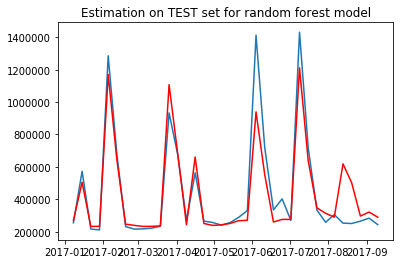

---------On train set---------
RMSE = 57750.992698005066
MAPE = 6.5872126019022685
MAE= 28032.319320594495
MSE= 3335177157.6050344


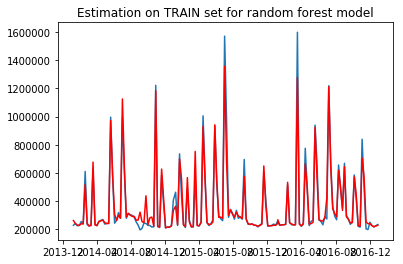

,name_variable,score (the higher the better)
12,Days_Uplifts,0.588704
10,Week,0.207720
13,Plage,0.071767
11,Year,0.054740
0,Meca_Cagnottage,0.028732
1,Meca_Lots Virtuels,0.020878
6,Pack_2 packs,0.014779
5,Pack_1 pack,0.012143
3,Meca_RI,0.000244
7,Pack_3 packs,0.000192


In [147]:
metric_MSE='neg_mean_squared_error'
metric_MAE='neg_median_absolute_error'
param_grid_RF = {'n_estimators': [1,5,10,20,50,70,100], 'criterion': ['mae','mse']}

rfg_fitted,RMSE_test,MAPE_test,df_var_importance=function_for_prediction(RandomForestRegressor(),
                                                       new_df,new_df_train,Y_train,new_df_test,Y_test,index_test,param_grid_RF,metric_MSE)

df_var_importance

This Data Frame tells us what variables have the biggest impact on the predictions. The Week variable influence a lot our results, because it allows to distinguish holidays, or religious event like christmas, where the sells can vary a lot. 
Moreover, in the Carrefour and Systeme U markets, the choice of the kind of discounts will affect the amount of sells more than in the other markets. 
The variable "Pack" is not very helpful for this model.

------
## Gradient Boosting
------

The best parameters for this model with the metric neg_mean_squared_error are : {'learning_rate': 0.1, 'loss': 'ls', 'n_estimators': 10}
---------On test set---------
RMSE = 144879.4297313888
MAPE = 21.31766276346134
MAE= 88866.4262683444
MSE= 20990049159.292427


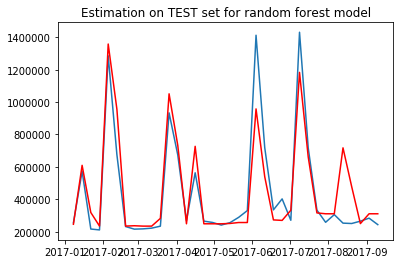

---------On train set---------
RMSE = 47940.83678050999
MAPE = 6.606218572579249
MAE= 24991.581172417038
MSE= 2298323831.2154994


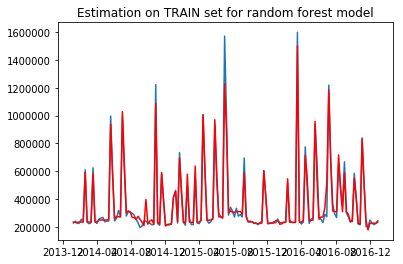

,name_variable,score (the higher the better)
10,Week,0.328898
12,Days_Uplifts,0.215782
11,Year,0.118161
13,Plage,0.114708
6,Pack_2 packs,0.092724
0,Meca_Cagnottage,0.045448
1,Meca_Lots Virtuels,0.038905
5,Pack_1 pack,0.028358
9,Pack_nan,0.016722
7,Pack_3 packs,0.000156


In [148]:
metric_MSE='neg_mean_squared_error'
metric_MAE='neg_median_absolute_error'
param_grid_GBR = {'loss': ['ls', 'lad', 'huber', 'quantile'], 'n_estimators': [5,10,50,80,100,200],'learning_rate':[0.1,0.5,0.8]}

GBR=GradientBoostingRegressor()
GBR_fitted,RMSE_test,MAPE_test,df_var_importance=function_for_prediction(GBR,
                                                    new_df,new_df_train,Y_train,new_df_test,Y_test,index_test,param_grid_GBR,metric_MSE)
df_var_importance

------
## XGBRegressor
-----

The best parameters for this model with the metric neg_median_absolute_error are : {'learning_rate': 0.5, 'max_depth': 7, 'n_estimators': 5}
---------On test set---------
RMSE = 131610.00909633195
MAPE = 18.405026022523952
MAE= 75479.22844328708
MSE= 17321194494.336582


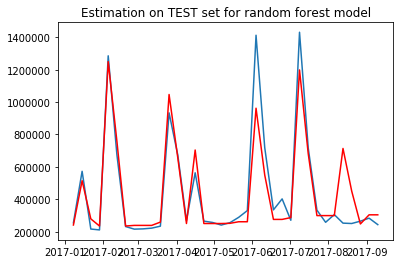

---------On train set---------
RMSE = 60146.10657870162
MAPE = 8.102523143636587
MAE= 31175.486431794063
MSE= 3617554136.576533


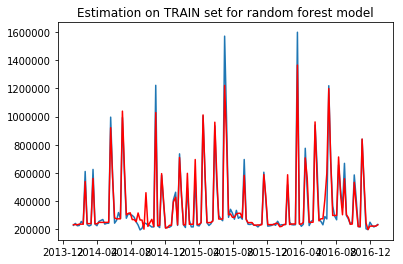

,name_variable,score (the higher the better)
10,Week,0.355958
12,Days_Uplifts,0.180995
11,Year,0.108597
13,Plage,0.098039
1,Meca_Lots Virtuels,0.092006
6,Pack_2 packs,0.082956
0,Meca_Cagnottage,0.048265
5,Pack_1 pack,0.024133
7,Pack_3 packs,0.006033
4,Meca_nan,0.003017


In [149]:
metric_MSE='neg_mean_squared_error'
metric_MAE='neg_median_absolute_error'
param_grid_xgb = {'max_depth': [1,3,7,9], 'n_estimators': [5,10,50,80,100,200],'learning_rate':[0.1,0.5,0.8]}


xgb = xgboost.XGBRegressor()

xgb_fitted,RMSE_test,MAPE_test,df_var_importance=function_for_prediction(xgb,
                                                    new_df,new_df_train,Y_train,new_df_test,Y_test,index_test,param_grid_xgb,metric_MAE)
df_var_importance

---
## AdaBoostRegressor
-------------------

The best parameters for this model with the metric neg_median_absolute_error are : {'n_estimators': 5}
---------On test set---------
RMSE = 113845.49752909604
MAPE = 18.249373580278387
MAE= 76032.55837927987
MSE= 12960797307.647411


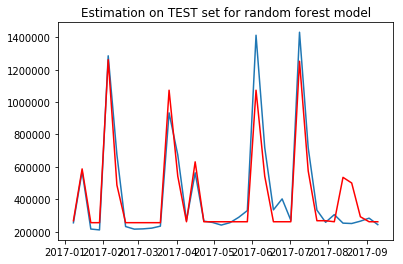

---------On train set---------
RMSE = 84191.1247226007
MAPE = 13.773998782367505
MAE= 52001.851656021536
MSE= 7088145482.056505


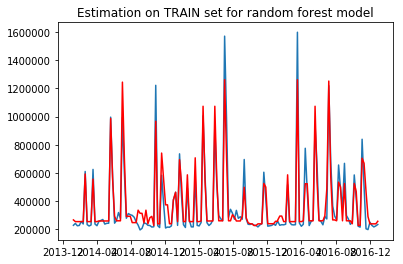

,name_variable,score (the higher the better)
12,Days_Uplifts,0.463832
10,Week,0.224761
13,Plage,0.158505
6,Pack_2 packs,0.073745
1,Meca_Lots Virtuels,0.028487
5,Pack_1 pack,0.022955
11,Year,0.021991
0,Meca_Cagnottage,0.005718
4,Meca_nan,0.000006
2,Meca_Multiple,0.000000


In [150]:
metric_MSE='neg_mean_squared_error'
metric_MAE='neg_median_absolute_error'
param_grid_ada = {'n_estimators': [5,10,50,80,100,200]}

seed = 7
num_trees = 30
ADABOOST_Specification = AdaBoostRegressor(n_estimators=num_trees, random_state=seed)
mod_fitted,RMSE_test,MAPE_test,df_var_importance=function_for_prediction(ADABOOST_Specification,
                                                    new_df,new_df_train,Y_train,new_df_test,Y_test,index_test,param_grid_ada,metric_MAE)
df_var_importance


----
# Select the predictions for all possible configurations
----


In [151]:
Date_to_predict='1.2017'
Week_to_predict='1'
Year_to_predict='2017'
df=pd.read_excel('/Users/newuser/Downloads/Waters.xlsx')
options_Mecanisme=df['Mecanisme'].unique().tolist()
options_Days_Uplifts=df['Days_Uplifts'].unique().tolist()
options_Plage=df['Plage'].unique().tolist()
options_Pack=df['Pack'].unique().tolist()
X_to_predict=[]
X_to_predict.append([Week_to_predict,Year_to_predict,np.nan,np.nan,np.nan,np.nan])
for meca in options_Mecanisme:
    for pack in options_Pack:
        for days_up in options_Days_Uplifts:
            for plage in options_Plage:
                if(not(pd.isnull(meca) or pd.isnull(pack) or np.isnan(days_up) or np.isnan(plage))):
                    X_to_predict.append([Week_to_predict,Year_to_predict,meca,pack,days_up,plage])
columns_x=['Week','Year','Mecanisme','Pack','Days_Uplifts','Plage']    
df_X=pd.DataFrame(columns=columns_x,data=X_to_predict)
new_X_df3=pd.get_dummies(df_X['Mecanisme'],prefix='Meca',dummy_na=True)
new_X_df4=pd.get_dummies(df_X['Pack'],prefix='Pack',dummy_na=True)
int_df2 = pd.concat([new_X_df3,new_X_df4],axis=1)
df_X=df_X.drop(['Mecanisme','Pack'],axis=1)
df_X=pd.concat([int_df2,df_X],axis=1)
df_X=df_X.fillna(0)
df_X.head(10)
#df_X contains all the possible configurations of sells for the product chosen a the begginning of this notebook 

,Meca_Cagnottage,Meca_Lots Virtuels,Meca_Multiple,Meca_RI,Meca_nan,Pack_1 pack,Pack_2 packs,Pack_3 packs,Pack_autre,Pack_nan,Week,Year,Days_Uplifts,Plage
0,0,0,0,0,1,0,0,0,0,1,1,2017,0.0,0.000000
1,0,1,0,0,0,0,1,0,0,0,1,2017,4.0,0.300000
2,0,1,0,0,0,0,1,0,0,0,1,2017,4.0,0.100000
3,0,1,0,0,0,0,1,0,0,0,1,2017,4.0,0.500000
4,0,1,0,0,0,0,1,0,0,0,1,2017,4.0,0.200000
5,0,1,0,0,0,0,1,0,0,0,1,2017,4.0,0.400000
6,0,1,0,0,0,0,1,0,0,0,1,2017,4.0,0.433333
7,0,1,0,0,0,0,1,0,0,0,1,2017,4.0,0.366667
8,0,1,0,0,0,0,1,0,0,0,1,2017,4.0,0.233333
9,0,1,0,0,0,0,1,0,0,0,1,2017,4.0,0.350000


**For the Random Forest Prediction** 
<br\><br\>
We made all the different configurations of the way to sell the next product and predicted the amount of products sold for every configuration. The following data frame is sorted. The first line correspond to the configuration the product has to be sold in order to sell the more. <br\><br\>
**For example**: <br\><br\>
If, absolutely, "1.448274e+06" products have to be sold during the week 1 in 2017, we advice to make a 6 days discount of 43% or 50% with a "two pack" and a "Lots Virtuels" configuration
<br\><br\>

In [152]:
Y_predict_rfg=rfg_fitted.predict(df_X)
pd_y=pd.DataFrame(columns=['prediction for next sell'],data=Y_predict_rfg)
X_Y=pd.concat([df_X,pd_y],axis=1)
X_Y=X_Y.sort_values(by=['prediction for next sell'], ascending=[False])
X_Y.head(10)

,Meca_Cagnottage,Meca_Lots Virtuels,Meca_Multiple,Meca_RI,Meca_nan,Pack_1 pack,Pack_2 packs,Pack_3 packs,Pack_autre,Pack_nan,Week,Year,Days_Uplifts,Plage,prediction for next sell
33,0,1,0,0,0,0,1,0,0,0,1,2017,6.0,0.433333,1.191631e+06
30,0,1,0,0,0,0,1,0,0,0,1,2017,6.0,0.500000,1.191631e+06
159,0,1,0,0,0,1,0,0,0,0,1,2017,6.0,0.433333,1.008713e+06
156,0,1,0,0,0,1,0,0,0,0,1,2017,6.0,0.500000,1.008713e+06
789,0,0,1,0,0,0,1,0,0,0,1,2017,6.0,0.433333,1.006041e+06
282,0,0,0,1,0,0,1,0,0,0,1,2017,6.0,0.500000,1.006041e+06
285,0,0,0,1,0,0,1,0,0,0,1,2017,6.0,0.433333,1.006041e+06
786,0,0,1,0,0,0,1,0,0,0,1,2017,6.0,0.500000,1.006041e+06
219,0,1,0,0,0,0,0,1,0,0,1,2017,6.0,0.500000,9.789025e+05
93,0,1,0,0,0,0,0,0,1,0,1,2017,6.0,0.500000,9.789025e+05


** Equivalently for Gradient Boosting **

In [153]:
Y_predict_xgb=GBR_fitted.predict(df_X)
pd_y=pd.DataFrame(columns=['prediction for next sell'],data=Y_predict_xgb)
X_Y=pd.concat([df_X,pd_y],axis=1)
X_Y=X_Y.sort_values(by=['prediction for next sell'], ascending=[False])
X_Y.head(10)

,Meca_Cagnottage,Meca_Lots Virtuels,Meca_Multiple,Meca_RI,Meca_nan,Pack_1 pack,Pack_2 packs,Pack_3 packs,Pack_autre,Pack_nan,Week,Year,Days_Uplifts,Plage,prediction for next sell
30,0,1,0,0,0,0,1,0,0,0,1,2017,6.0,0.500000,1.401519e+06
789,0,0,1,0,0,0,1,0,0,0,1,2017,6.0,0.433333,1.401519e+06
282,0,0,0,1,0,0,1,0,0,0,1,2017,6.0,0.500000,1.401519e+06
285,0,0,0,1,0,0,1,0,0,0,1,2017,6.0,0.433333,1.401519e+06
786,0,0,1,0,0,0,1,0,0,0,1,2017,6.0,0.500000,1.401519e+06
33,0,1,0,0,0,0,1,0,0,0,1,2017,6.0,0.433333,1.401519e+06
537,1,0,0,0,0,0,1,0,0,0,1,2017,6.0,0.433333,1.071707e+06
534,1,0,0,0,0,0,1,0,0,0,1,2017,6.0,0.500000,1.071707e+06
807,0,0,1,0,0,0,1,0,0,0,1,2017,7.0,0.433333,1.034073e+06
300,0,0,0,1,0,0,1,0,0,0,1,2017,7.0,0.500000,1.034073e+06


---
# Conslusion :
---

- A first conclusion can be made about the non effectiveness of the MAPE metric to estimate the accuracy of the model and can be seen thanks to the graph of test prediction of sells.
- Also, to predict the configurations, different results appear but the structure is conserved. 
- RMSE can be more interesting to study (in this case at least) because of the following example :

- If we want penalize more the model when there is a huge difference between our prediction and the true value, the RMSE is interesting. Imagine a company has absolutely to sell the 1000 milk bottle it produced for next week. If the model predict very badly the number of sells, it can affect a lot the revenue figure of the company. On the contrary if we don't care 
- The graphs seem to predict much better for the beggining of 2017 than the end. This is a good point because it means the model is better than indicated with the metrics if we predict in a short period of time 
- It could be interesting to train the model from 2014 until one or two month before the last data and observe the accuracy. 
- Also the sells could be divided by the days uplift in order to study a day sell